In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import h3
from shapely.geometry import Polygon, Point
import contextily as ctx

In [ ]:
train = pd.read_csv('../data/raw_data/train.csv')
test = pd.read_csv('../data/raw_data/test.csv')

combined = pd.concat([train, test], axis=0)


AttributeError: module 'pandas' has no attribute 'write_parquet'

In [6]:
# write to parquet

combined.to_parquet("../data/raw_data/yellow_09-15_data.parquet", engine="pyarrow", index=False)


In [2]:
old_data = pd.read_parquet('../data/processed_data/kaggle2018_processed_from_coords.parquet')
new_data = pd.read_parquet('../data/processed_data/yellow_processed_from_ids.parquet')

In [3]:
train = pd.read_csv('../data/raw_data/kaggle2018_train.csv')
test = pd.read_csv('../data/raw_data/kaggle2018_test.csv')

latlon = pd.concat([train[['pickup_latitude', 'pickup_longitude']], test[['pickup_latitude', 'pickup_longitude']]])

In [32]:
# Drop outliers outside of NYC
latlon = latlon[(latlon['pickup_latitude'] > 40.4) & (latlon['pickup_latitude'] < 41) &
                (latlon['pickup_longitude'] > -74.3) & (latlon['pickup_longitude'] < -73.7)]

In [35]:
sample = latlon.sample(10000)

In [36]:
# Create a GeoDataFrame
sample = gpd.GeoDataFrame(sample, geometry=gpd.points_from_xy(sample['pickup_longitude'], sample['pickup_latitude']))

In [40]:
np.min(sample['pickup_latitude']), np.max(sample['pickup_latitude']), np.min(sample['pickup_longitude']), np.max(sample['pickup_longitude'])

(40.505092, 40.943870544433594, -73.999982, -73.719208)

(-74.3, -73.7)

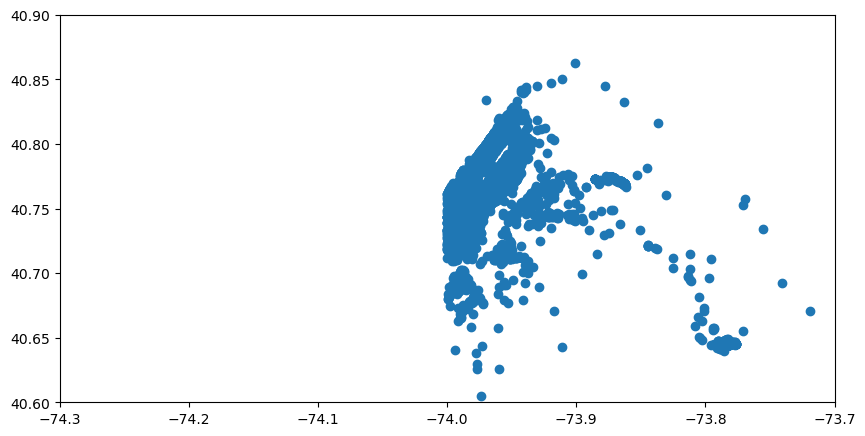

In [38]:
sample.plot(aspect=1, figsize=(10, 10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.3, -73.7)

In [34]:
old_data.head()

,H3LocationID,day,time,pickup_count
0,882a100001fffff,Friday,20:00:00,1
1,882a100001fffff,Monday,11:00:00,1
2,882a100001fffff,Monday,13:00:00,1
3,882a100001fffff,Monday,13:30:00,1
4,882a100001fffff,Saturday,00:00:00,1


/var/folders/lc/6n3k9ht52fxdnv5mqyw8tngh0000gn/T/ipykernel_12874/3775802891.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones['geometry'].centroid


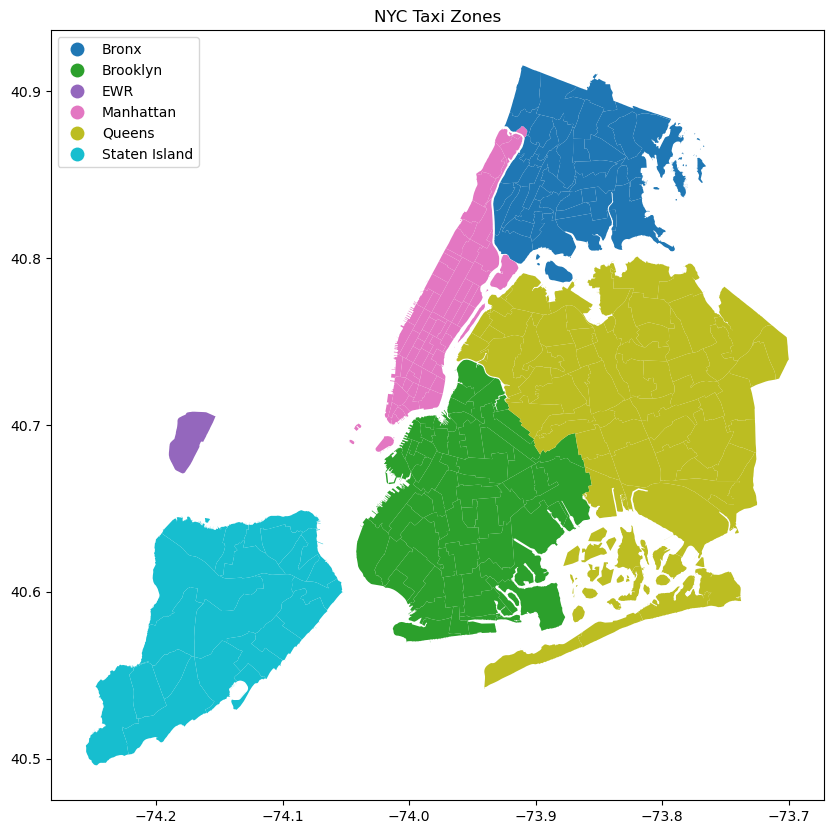

In [45]:
zones = gpd.read_file('../data/taxi_zones/taxi_zones.shp')
zones = zones.to_crs(epsg=4326)
zones['geometry'].centroid

# Plot the shapefile
zones['borough'] = zones['borough'].str.replace('Other', 'Staten Island')
zones.plot(column='borough', figsize=(10, 10), legend=True, legend_kwds={'loc': 'upper left'})  # Plot the zones

# Label each zone with the LocationID
zones['coords'] = zones['geometry'].apply(lambda x: x.representative_point().coords[:])  # Get the coordinates of the zones
zones['coords'] = [coords[0] for coords in zones['coords']]  # Extract the coordinates from the list
# for idx, row in zones.iterrows():
#     plt.annotate(text=str(row['LocationID']), xy=row['coords'], horizontalalignment='center', fontsize=5)  # Annotate the zones with the LocationID

plt.title('NYC Taxi Zones')
# plt.axis('off')  # Turn off the axis

plt.show()

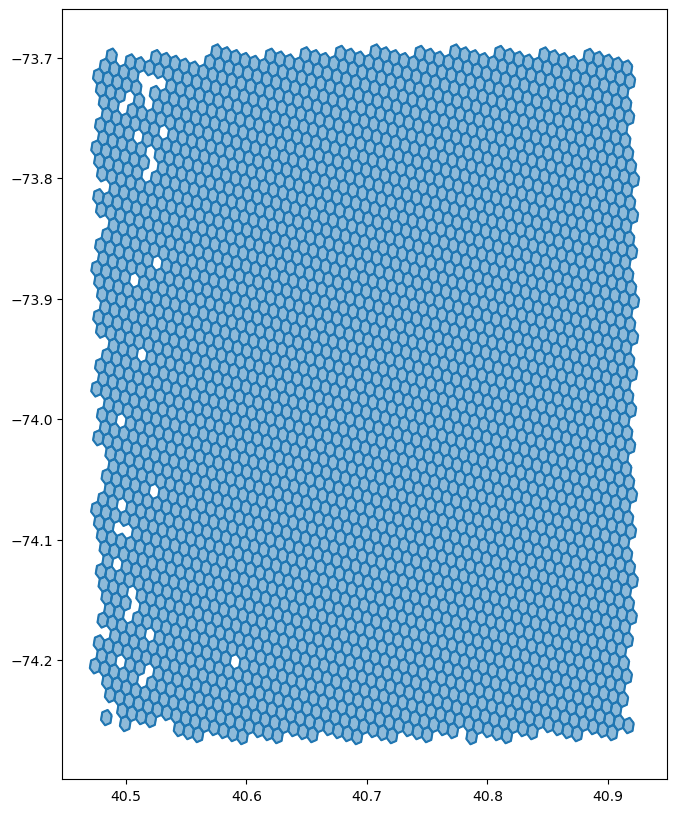

In [41]:
unique_locations = old_data['H3LocationID'].unique()

# Get the hexagons
hexagons = [h3.cell_to_boundary(h) for h in unique_locations]
polygons = [Polygon(h) for h in hexagons]
gdf = gpd.GeoDataFrame(geometry=polygons)
gdf.crs = 'EPSG:4326'

# Plot the hexagons
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, aspect='equal')
gdf.plot(ax=ax, alpha=0.5, edgecolor='k', aspect='equal')
plt.show()

In [51]:
unique_locations = old_data['H3LocationID'].unique()
hexagons = [h3.cell_to_boundary(h) for h in unique_locations]
polygons = [Polygon(h) for h in hexagons]
gdf = gpd.GeoDataFrame(geometry=polygons)
gdf.crs = 'EPSG:4326'

gdf.head()

,geometry
0,"POLYGON ((40.86288 -73.77994, 40.86183 -73.786..."
1,"POLYGON ((40.855 -73.77752, 40.85395 -73.78392..."
2,"POLYGON ((40.86525 -73.79075, 40.86421 -73.797..."
3,"POLYGON ((40.85737 -73.78833, 40.85633 -73.794..."
4,"POLYGON ((40.86838 -73.77155, 40.86734 -73.777..."


KeyboardInterrupt: 

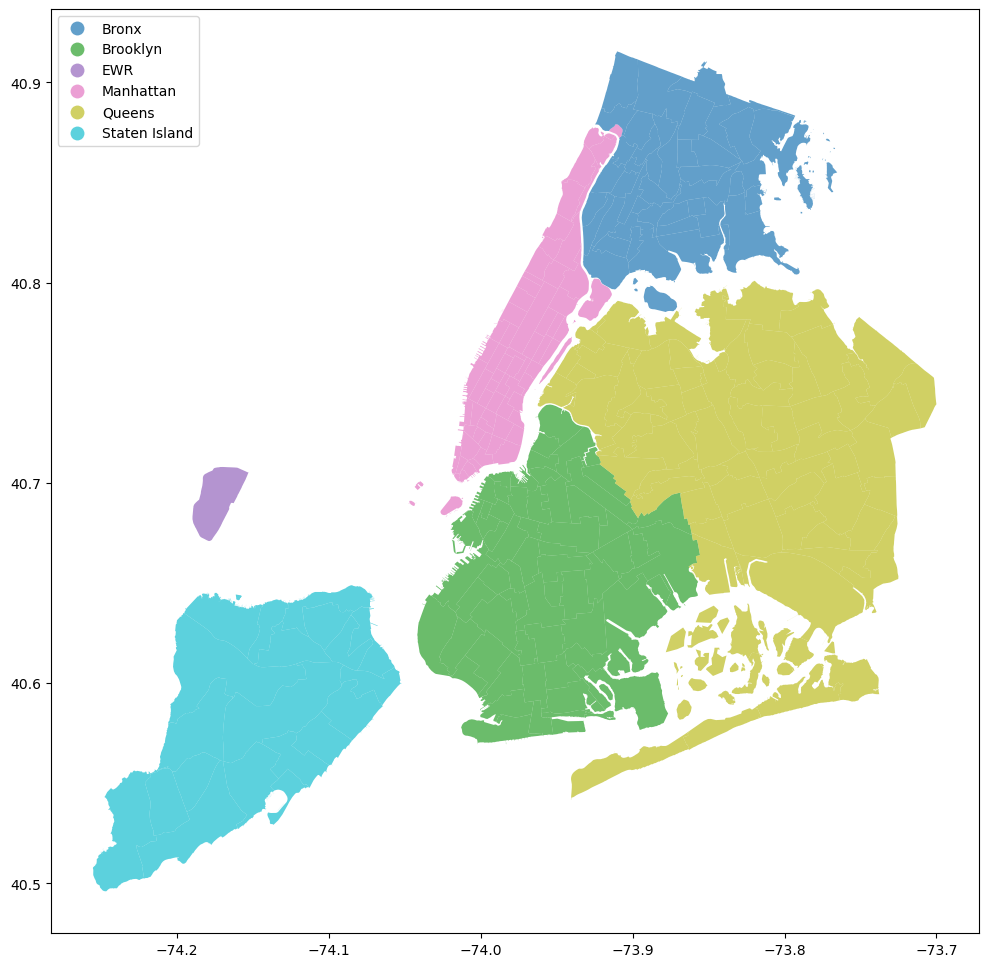

In [4]:
# Ensure both GeoDataFrames are in the same CRS
zones = gpd.read_file('../data/taxi_zones/taxi_zones.shp')
zones = zones.to_crs(epsg=4326)

# Correct borough names
zones['borough'] = zones['borough'].str.replace('Other', 'Staten Island')

# Extract coordinates for labeling
zones['coords'] = zones['geometry'].apply(lambda x: x.representative_point().coords[:])
zones['coords'] = [coords[0] for coords in zones['coords']]

# Prepare H3 hexagons
unique_locations = old_data['H3LocationID'].unique()
hexagons = [h3.cell_to_boundary(h) for h in unique_locations]
polygons = [Polygon(h) for h in hexagons]
gdf = gpd.GeoDataFrame(geometry=polygons)
gdf.crs = 'EPSG:4326'

# Plot both layers
fig, ax = plt.subplots(figsize=(12, 12))

# Plot taxi zones
zones.plot(column='borough', ax=ax, alpha=0.7, legend=True, legend_kwds={'loc': 'upper left'})

# plot latlon points
# Ensure zones CRS is EPSG:4326
zones = zones.to_crs(epsg=4326)

# Filter the latitude/longitude points
filtered = latlon.iloc[:100]
filtered = latlon[
    (latlon['pickup_latitude'] > 40.5) & 
    (latlon['pickup_latitude'] < 40.9) & 
    (latlon['pickup_longitude'] > -74.3) & 
    (latlon['pickup_longitude'] < -73.7)
]

# Convert to GeoDataFrame
filtered['geometry'] = filtered.apply(
    lambda row: Point(row['pickup_longitude'], row['pickup_latitude']), axis=1
)
points_gdf = gpd.GeoDataFrame(filtered, geometry='geometry', crs='EPSG:4326')

# Plot the points
points_gdf.plot(ax=ax, color='red', alpha=0.5, markersize=1, label='Pickup Locations')


# # Plot H3 hexagons
# gdf.boundary.plot(ax=ax, color='red', linewidth=0.5, label='H3 Boundaries')
# gdf.plot(ax=ax, alpha=0.3, edgecolor='black')

# # Annotate Taxi Zones with LocationID
# for idx, row in zones.iterrows():
#     plt.annotate(text=str(row['LocationID']), xy=row['coords'], horizontalalignment='center', fontsize=5)

# Title and legend
plt.title('NYC Taxi Zones with H3 Hexagonal Grid', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
# plt.axis('off')  # Turn off axis

plt.show()


In [61]:
filtered.head()

,pickup_latitude,pickup_longitude
0,40.721319,-73.844311
1,40.711303,-74.016048
2,40.761270,-73.982738
3,40.733143,-73.987130
4,40.768008,-73.968095


In [27]:
# Convert the old data from H3LocationID to polygons for plotting
old_data['geometry'] = old_data['H3LocationID'].apply(lambda x: Polygon(h3.cell_to_boundary(x)))
gdf = gpd.GeoDataFrame(old_data, geometry='geometry', crs="EPSG:4326")  # Use WGS 84 coordinate system

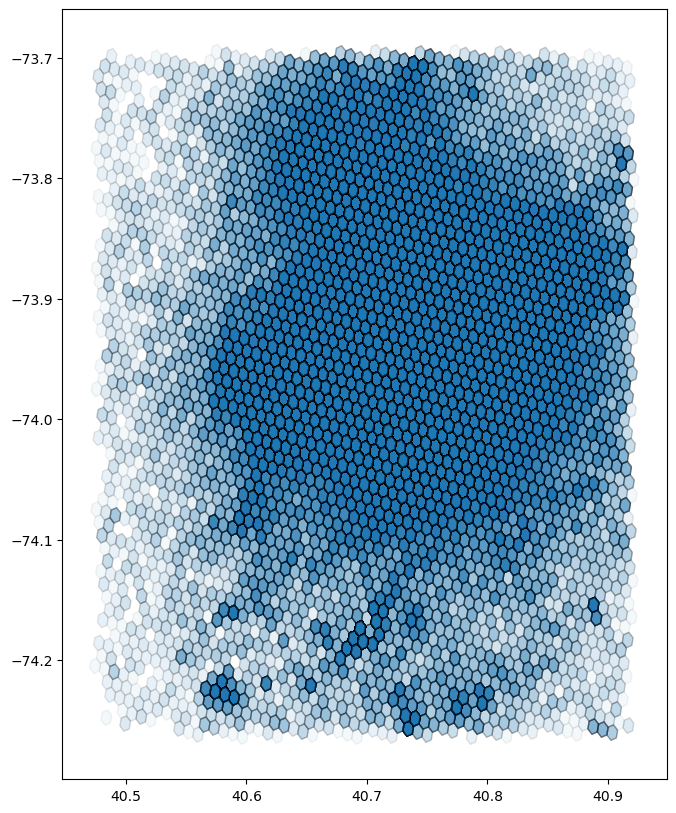

In [29]:
gdf.plot(figsize=(10, 10), alpha=0.05, edgecolor='black', aspect='equal')

plt.show()